# PRODUCTS

**A. CLEAN UP AND PREPARE PRODUCT DATA**

A.1 Load and plot

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os

# pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from operator import itemgetter
import re
import seaborn as sns
from ipywidgets import IntProgress
from IPython.display import display
import time

#Website object lists : https://7esl.com/tools-and-equipment/#Technological_Gadgets

In [2]:
os.getcwd()

'/Users/lou/Documents/Travail/master 2/ADA/epfl-ada-2019-project-bubble582/source'

In [3]:
#load the data
hh_demographic = pd.read_csv('../data/dunnhumby_complete_csv/hh_demographic.csv', sep = ',')

transaction_data = pd.read_csv('../data/dunnhumby_complete_csv/transaction_data.csv', sep = ',')

product = pd.read_csv('../data/dunnhumby_complete_csv/product.csv', sep = ',')

# This is a list a created. It is a small file, I pushed it in data in order you can have it at home
ObjectLabels = pd.read_csv('../data/dunnhumby_complete_csv/GroceryLists.csv', sep = ',')
ObjectLabels.columns = ['ITEM','LABEL']

First we get interested by the different departments in the commercial center. We reorder the departments and plot the number of different products we can find per department. 

In [4]:
# REORDERING PART: 
ordered_manufacturer= product.MANUFACTURER.astype(int).sort_values()
ordered_manufacturer= ordered_manufacturer.unique()

product['MANUFACTURER'] = pd.Categorical(product['MANUFACTURER'],
                      ordered = True,
                      categories = ordered_manufacturer)

#Drop unwanted products: 
unwanted_departments = ['','PHOTO', 'VIDEO', 'MISC. TRANS.', 'MISC SALES TRAN','MEAT-WHSE', 'COUP/STR & MFG']
product = product[product['DEPARTMENT'].apply(lambda x: x not in unwanted_departments)]

print ('The order of the manufacturer categories is :', ordered_manufacturer)

The order of the manufacturer categories is : [   1    2    3 ... 6475 6476 6477]


In [5]:
#We create the LABEL column in the product dataframe to use later: 
product['LABEL'] = product['DEPARTMENT']
product.head(4)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,LABEL
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,GROCERY
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,PASTRY
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,GROCERY
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,GROCERY


[Text(0.5, 1.0, 'Number of occurences per department in product data')]

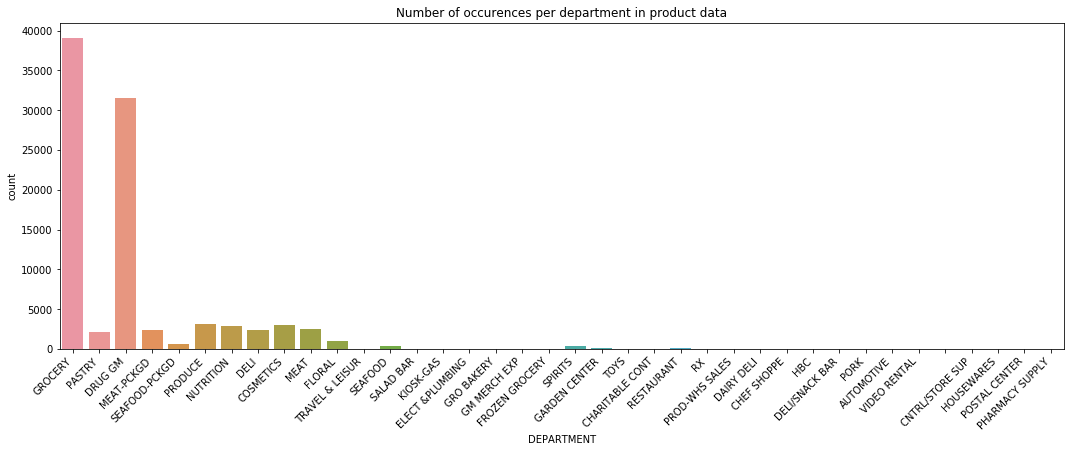

In [6]:
#Plot the number of products per department: 
department = product.groupby(['DEPARTMENT']).count()

fig, axs = plt.subplots(1,1, figsize = (18,6))
sns.countplot(product['DEPARTMENT'], ax = axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
axs.set(title = 'Number of occurences per department in product data')

As we can see in the previous barplots, the departments with the highest number of referenced products in this study are the grocery with almost 40000 products, and the drug GM (which is probably a drug store) with more than 30000 products. We are going to focus on these 2 mains stores in a first time.

**B. GROCERY DATA PREPROCESSING**

In this part we are interested to clean up and categorize the different products from the grocery store. We want to explain what purpose they serve (food, households, & hygien products, pet products etc.). We create a special Grocery dataframe for this purpose.

In [7]:
#we extract the grocery product data which is the main supermarket in the commercial center
Grocery= pd.DataFrame(product[product['DEPARTMENT'] == 'GROCERY'])
Grocery.head(4)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,LABEL
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,GROCERY
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,GROCERY
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,GROCERY
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ,GROCERY


The only product descriptions provided by the Grocery data are few words descriptions found in COMMODITY_DESC and SUB_COMMODITY_DESC columns. These descriptions are not standardized, no categories arise from them. 

In a first time, we want to categorize the words in the descriptions using different labels (produce, households, technology ...). To do so we create a function called "LabelizeProduct". This function first recognizes the different words or words sequences in the description. These words or words sequences are associated with a certain label in a list of shopping items ("GroceryList.csv"). In a second time, based on the fuzzywuzzy librairy, the "LabelizeProduct" gives a score with comparing the description and the shopping item corresponding to words sequence identified. Finally, the functions keep the label for which the score is the highest. 

In [8]:
"""
LabelizeProduct: This function is able to categorize the products 
given in data with looking at a labelled list of words. This labelled list of words is a lexique of grocery and shopping words. 

@input: 
- threshold is the smallest fuzzywuzzy score accepted to declare a match. 
    (fuzzywuzzy gives a score of string matching over 100). If score lower than threshold, the item is categorized as 'not found'. 
- data: the  dataset to categorize, dataCol is the column of the dataset to categorize
- wordList: the list of words associated with a Label. wordList : ['ITEM','LABEL']

@output: ?
"""
def LabelizeProduct(data, dataCol, threshold, wordList) :
    #Progress bar: 
    max_count = len(data.index)
    
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    
    display(f) # display the bar
    
    Out = pd.DataFrame(index = data.index, columns = ['Item','Ratio','Label'])
    
    #count to show progression when running (can take few minutes)
    loopCounter = 0
    
    # iterate on the index of the dataset to categorize
    for indexCOM in data.index :
        """
        if (loopCounter%100 == 0): 
            print(loopCounter)
        """
        
        # the item to categorize in the dataCol
        item = dataCol.loc[indexCOM]
        #a vector to keep all the matches within the grocerylist.csv
        match = []
        #set the output table
        Out.Item[indexCOM] = item
        Out.Label[indexCOM] = 'not found'
        Out.Ratio[indexCOM]= 0
        
        #iterate on the wordList's items (belonging to a certain label)
        for index,label in enumerate(wordList.LABEL) :
            
            # get all the separated words in the wordList item
            line = re.split(' |&|/',wordList.ITEM[index])
            
            #iterate on the separated words in the wordList item
            for word in line:
                #manage case (everything in lowercase)
                lword= word.lower()
                litem = item.lower()

                # if we find the word from wordList item, in the description of the data:
                # we calculate the fuzzywuzzy ratio(%) and we append the match in the match vector
                if litem.find(lword)!= -1:
                    ratio = fuzz.token_sort_ratio(str.lower(item), str.lower(lword))
                    match.append((indexCOM,line,ratio,label))
                    
        # if the match vector is not empty, then we attribute the label corresponding to the max ratio 
        #to the description            
        if (match) and (max(match,key=itemgetter(2))[2]>= threshold)  :
            Out.Label[indexCOM] = max(match,key=itemgetter(2))[3]
            Out.Ratio[indexCOM]= max(match,key=itemgetter(2))[2]
            
        f.value += 1
        loopCounter += 1
            
    return Out

We use our new function "LabelizeProduct" to find the main categories in the Grocery department.

In [10]:
LabelledSUB = LabelizeProduct(Grocery, Grocery.SUB_COMMODITY_DESC, 0, ObjectLabels)
Labelled = LabelizeProduct(Grocery, Grocery.COMMODITY_DESC, 0, ObjectLabels) 

IntProgress(value=0, max=39021)

IntProgress(value=0, max=39021)

In [11]:
#Create two columns for the score of each label from the commodity and sub_commodity. 
Labelled['RatioSUB']= LabelledSUB.Ratio
Labelled['LabelSUB']= LabelledSUB.Label

In [12]:
#Estimate the error: 

# number of item where SUB_COMMODITY_DESC and COMMODITY_DESC have a different label. (Knowing the the label kept 
# at the end is the one with the highest score 
Labelled[Labelled['Label']!= Labelled['LabelSUB']].count()

# total of not found for both SUB_COMMODITY_DESC and COMMODITY_DESC
Labelled[(Labelled['Label'] == 'not found') & (Labelled['LabelSUB'] == 'not found')].count()

# Total number of highest score lower than 20. Most often it is because we compare a small word to 
# a whole item description (several words).  
Labelled[(Labelled['Ratio']<20) & (Labelled['RatioSUB'] < 20)].count()
Labelled[(Labelled['Ratio']<20) & (Labelled['RatioSUB'] < 20)]

,Item,Ratio,Label,RatioSUB,LabelSUB
2732,HISPANIC,0,not found,18,HOUSEHOLDS
2933,HISPANIC,0,not found,0,not found
2970,HISPANIC,0,not found,0,not found
4908,REFRGRATD DOUGH PRODUCTS,0,not found,0,not found
5192,HISPANIC,0,not found,18,HOUSEHOLDS
...,...,...,...,...,...
77202,HISPANIC,0,not found,0,not found
77361,REFRGRATD DOUGH PRODUCTS,0,not found,0,not found
77449,REFRGRATD DOUGH PRODUCTS,0,not found,0,not found
79960,HISPANIC,0,not found,0,not found


We create a second function "putLabel" that sets the label with the highest fuzzy ratio in between the dataset's columns that were categorized (here COMMODITY_DESC and SUB_COMMODITY_DESC) in the main data set (here Grocery). 

In [15]:
"""
putLabel: his is the function that put the Labels in the main data Table. It compares the 
labels thanks to the fuzzy scores for 2 different labelledData 
(ex: grocery labelled for COMMODITY and SUB_COMMODITY) and chooses the best one.

@input: 
- LabelledData: ? 
- data: ?

@output:? 
"""
def putLabel(LabelledData, data) :
    #Progress bar: 
    max_count = len(LabelledData.index)
    
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    
    for line in LabelledData.index : 

        maxRatio = max(LabelledData.Ratio.loc[line], LabelledData.RatioSUB.loc[line])
        if LabelledData.Ratio.loc[line] == maxRatio :
            data['LABEL'].loc[line] = LabelledData.Label.loc[line]
        
        elif LabelledData.RatioSUB.loc[line] == maxRatio :
            data['LABEL'].loc[line] = LabelledData.LabelSUB.loc[line]
        
        f.value += 1
    return 0

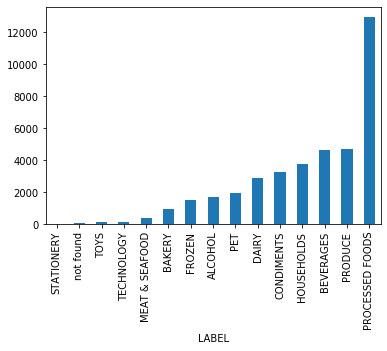

In [16]:
#Put the labels in the main data set Grocery and show results: 
putLabel(Labelled, Grocery)

#Plot: 
LabelCount = Grocery.groupby('LABEL').count()
LabelCount.BRAND.sort_values().plot.bar()

In [17]:
#Save to csv: 
if not os.path.exists("saved_structures"):
    os.makedirs("saved_structures")

Grocery.to_csv("saved_structures/'Grocery.csv", sep='\t', index=False)

As we can see in the following table the Grocery store product have been Labelled. Error of classification are possible (even if low rate --> to estimate, HOW ?). Indeed the "LabelizeProduct" recognizes words that are provided in the "wordList" to the function. The accuracy of the classification relies on the thoroughness of this word list. Moreover if the word list does not contain enough words, the quantity of 'not found' increases drastically.

In [18]:
Grocery.groupby('LABEL').count()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
LABEL,,,,,,,
ALCOHOL,1698,1698,1698,1698,1698,1698,1698
BAKERY,958,958,958,958,958,958,958
BEVERAGES,4660,4660,4660,4660,4660,4660,4660
CONDIMENTS,3231,3231,3231,3231,3231,3231,3231
DAIRY,2917,2917,2917,2917,2917,2917,2917
FROZEN,1533,1533,1533,1533,1533,1533,1533
HOUSEHOLDS,3745,3745,3745,3745,3745,3745,3745
MEAT & SEAFOOD,374,374,374,374,374,374,374
PET,1971,1971,1971,1971,1971,1971,1971


**C. LET'S DO IT AGAIN WITH DRUG GM**
**Question** what is drug gm? If you're a retailer, the products you sell fall into one of two broad merchandise categories. One is groceries and food products, and the other is general merchandise, which is a broad catchall term for pretty much everything that's not groceries – from hearing aid batteries to major appliances. Some definitions go a bit further in describing who is or is not a general merchandise retailer, excluding things like building supplies or secondhand goods. Link: https://smallbusiness.chron.com/meaning-general-merchandise-68673.html

In [19]:
#We extract the drug gm product data which is the second main store in the commercial center
DrugGM = pd.DataFrame(product[product['DEPARTMENT'] == 'DRUG GM'])
DrugGM.head(4)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,LABEL
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1),DRUG GM
11,26889,32,DRUG GM,National,MAGAZINE,TV/MOVIE-MAGAZINE,,DRUG GM
20,27334,69,DRUG GM,Private,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,,DRUG GM
108,29574,69,DRUG GM,Private,STATIONERY & SCHOOL SUPPLIES,SCHOOL SUPPLIES,1 CT,DRUG GM


In [20]:
#Use LabelizeProduct to label the COMMODITY_DESC column from Drug GM department
LabelledDGM = LabelizeProduct(DrugGM, DrugGM.COMMODITY_DESC, 0,ObjectLabels) 

#Use LabelizeProduct to label the SUB_COMMODITY_DESC column from Drug GM department
LabelledSUBDGM = LabelizeProduct(DrugGM, DrugGM.SUB_COMMODITY_DESC, 0,ObjectLabels) 

IntProgress(value=0, max=31529)

IntProgress(value=0, max=31529)

In [21]:
#Put the labels in the main data set Drug GM
LabelledDGM['RatioSUB'] = LabelledSUBDGM.Ratio
LabelledDGM['LabelSUB'] = LabelledSUBDGM.Label

putLabel(LabelledDGM, DrugGM)

0

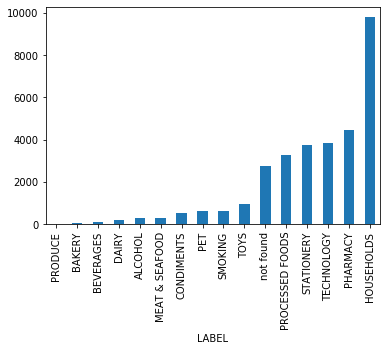

In [22]:
# show results
LabelDGMCount= DrugGM.groupby('LABEL').count()
LabelDGMCount.BRAND.sort_values().plot.bar()

In [23]:
#We would like to estimate the error

# number of item where SUB_COMMODITY_DESC and COMMODITY_DESC have a different label. (Knowing the the label kept 
# at the end is the one with the highest score  
LabelledDGM[LabelledDGM['Label']!=LabelledDGM['LabelSUB']].count()

# total of not found for both SUB_COMMODITY_DESC and COMMODITY_DESC
LabelledDGM[(LabelledDGM['Label'] == 'not found') & (LabelledDGM['LabelSUB'] == 'not found')].count()

# Total number of highest score lower than 20. Most often it is because we compare a small word to 
# a whole item description (several words).  
LabelledDGM[(LabelledDGM['Ratio']<20) & (LabelledDGM['RatioSUB'] < 20)].count()
LabelledDGM[(LabelledDGM['Ratio']<60) & (LabelledDGM['RatioSUB'] < 20)]

,Item,Ratio,Label,RatioSUB,LabelSUB
20,DIETARY AID PRODUCTS,52,PHARMACY,0,not found
108,STATIONERY & SCHOOL SUPPLIES,56,STATIONERY,0,not found
180,FIRST AID PRODUCTS,43,PHARMACY,0,not found
251,CANDY - PACKAGED,53,PROCESSED FOODS,0,not found
335,SPRING/SUMMER SEASONAL,43,CONDIMENTS,0,not found
...,...,...,...,...,...
92220,EASTER,0,not found,0,not found
92238,STATIONERY & SCHOOL SUPPLIES,56,STATIONERY,0,not found
92240,APPAREL,0,not found,0,not found
92339,EASTER,0,not found,0,not found


**D. ALL THE OTHER SHOPS: DELI, PRODUCE, NUTRITION, COSMETICS etc.**

The shop DELI needs also to be categorized. Since all the other shops are specialized the labels are easy to infer. Indeed it corresponds to the shop specialization. We also put the computed Label in the main dataset product (Grocery, Drug GM and DELI). 

In [24]:
# categorize the data in DELI
DELI = product[product['DEPARTMENT'] == 'DELI']
LabelledDELI = LabelizeProduct(DELI, DELI.COMMODITY_DESC, 0, ObjectLabels)
LabelledSUBDELI = LabelizeProduct(DELI, DELI.SUB_COMMODITY_DESC, 0, ObjectLabels)

IntProgress(value=0, max=2354)

IntProgress(value=0, max=2354)

In [25]:
#add DELI labels in the product dataframe and show results
LabelledDELI['RatioSUB'] = LabelledSUBDELI.Ratio
LabelledDELI['LabelSUB'] = LabelledSUBDELI.Label
putLabel(LabelledDELI, DELI)

/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

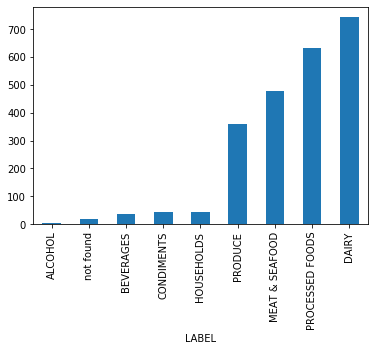

In [26]:
DELILabelCount = DELI.groupby('LABEL').count()
DELILabelCount.BRAND.sort_values().plot.bar()

In [27]:
#We standardize some labels for the seek of the vizualization. 
# I had trouble with the label setting in the main data set product. This is a shitty implementation but working. 
#I have to figure it out

product.DEPARTMENT.loc[product['DEPARTMENT']== 'DAIRY DELI'] = 'DELI'

product.LABEL.loc[product['DEPARTMENT']== 'MEAT'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'MEAT-PCKGD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'SEAFOOD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'SEAFOOD-PCKGD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'FROZEN GROCERY'] = 'FROZEN'
product.LABEL.loc[product['DEPARTMENT']== 'PHARMACY SUPPLY'] = 'PHARMACY'
product.LABEL.loc[product['DEPARTMENT']== 'PORK'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'RX'] = 'PHARMACY'
product.LABEL.loc[product['DEPARTMENT']== 'HOUSEWARES'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'ELECT &PLUMBING'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'HBC'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'DELI/SNACK BAR'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'CHARITABLE CONT'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'PROD-WHS SALES'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'GM MERCH EXP'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'CNTRL/STORE SUP'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== ' '] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'GRO BAKERY'] = 'BAKERY'
product.LABEL.loc[product['DEPARTMENT']== 'PASTRY'] = 'BAKERY'
product.LABEL.loc[product['DEPARTMENT']== 'AUTOMOTIVE'] = 'STATIONERY'
product.LABEL.loc[product['DEPARTMENT']== 'POSTAL CENTER'] = 'PROCESSED FOODS'
product.LABEL.loc[product['DEPARTMENT']== 'CHEF SHOPPE'] = 'PROCESSED FOODS'
product.LABEL.loc[product['DEPARTMENT']== 'TRAVEL & LEISUR'] = 'PRODUCE'
product.LABEL.loc[product['DEPARTMENT']== 'SALAD BAR'] = 'RESTAURANT'
product.LABEL.loc[product['DEPARTMENT']== 'GARDEN CENTER'] = 'FLORAL'
product.LABEL.loc[product['DEPARTMENT']== 'KIOSK-GAS'] = 'GASOLINE'
product.LABEL.loc[product['DEPARTMENT']== 'SPIRITS'] = 'ALCOHOL'

product.LABEL.loc[product['DEPARTMENT'] == 'GROCERY'] = Grocery.LABEL
product.LABEL.loc[product['DEPARTMENT'] == 'DRUG GM'] = DrugGM.LABEL
product.LABEL.loc[product['DEPARTMENT'] == 'DELI'] = DELI.LABEL

product.LABEL.unique()

array(['FROZEN', 'BAKERY', 'PRODUCE', 'PROCESSED FOODS', 'CONDIMENTS',
       'PHARMACY', 'STATIONERY', 'HOUSEHOLDS', 'DAIRY', 'BEVERAGES',
       'MEAT & SEAFOOD', 'NUTRITION', 'COSMETICS', 'PET', 'ALCOHOL',
       'not found', 'SMOKING', 'TECHNOLOGY', 'FLORAL', 'RESTAURANT',
       'GASOLINE', 'TOYS', nan, 'VIDEO RENTAL'], dtype=object)

We produce a final plot to show our results.

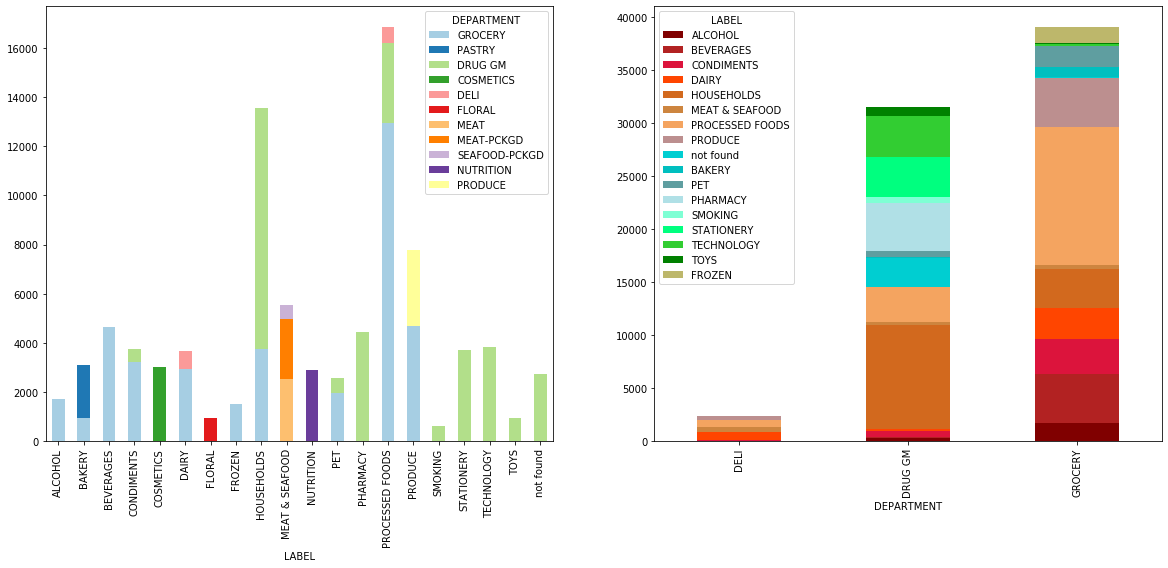

In [28]:
ProductLabels = product.groupby('LABEL').count()

ProductLabels2 = product.groupby(by = ['DEPARTMENT','LABEL']).count()

ProductDepartment = product.groupby(by = ['LABEL','DEPARTMENT']).count()
#ProductLabels2 = ProductLabels2.drop(ProductLabels2[ProductLabels2['BRAND'] <=10].index)

#palette : 
my_palette = ["maroon","firebrick","crimson", "orangered","chocolate", "peru","sandybrown","rosybrown","darkturquoise"
        ,"c","cadetblue","powderblue","aquamarine","springgreen","limegreen","green","darkkhaki"]
sns.set_palette(my_palette)


fig = plt.figure(figsize = (20,8))

# Divide the figure into a 2x1 grid, and give  the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 2x1 grid, and give the second section
ax2 = fig.add_subplot(122)

ProductDepartment.BRAND[ProductDepartment['BRAND'] > 500].unstack().plot.bar(color = sns.color_palette("Paired"),ax = ax1,stacked = True)
ProductLabels2.loc[['DRUG GM','GROCERY','DELI']].BRAND.unstack().plot.bar(color = sns.color_palette(),ax = ax2,stacked = True)


fig.subplots_adjust(hspace = 1.3)
fig.subplots_adjust(wspace = 0.2)


In [29]:
#Save to csv: 
if not os.path.exists("saved_structures"):
    os.makedirs("saved_structures")

product.to_csv("saved_structures/updated_prod3.csv", sep ='\t', index = False)

In the left barplot we observe where we can find the different product types. In x-axis displays the product type and the color label gives the shop (DEPARTMENT) where the product can be found. For example we can see that the households product are mainly found in the drug store (DRUG GM), and most of the meat and seafood products are found in the meat and meat-pckgd shops. 

The right barplot shows the proportions of the different products types, that we can find in the "unspecialized" shops (Deli, the grocery, and the drug store). For example we can see that Deli sales only food products, whereas the drug store proposes an important variety of household products.

In [31]:
product[product['LABEL']== 'ALCOHOL']

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,LABEL
353,37932,1490,GROCERY,National,LIQUOR,COCKTAIL MIXES-FLUID:ADD LIQ,LITER,ALCOHOL
746,49165,1490,GROCERY,National,LIQUOR,COCKTAIL MIXES-FLUID:ADD LIQ,LITER,ALCOHOL
2594,142934,2384,GROCERY,National,LIQUOR,COCKTAIL MIXES-FLUID:ADD LIQ,1 LTR,ALCOHOL
2608,145106,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,1.5 LTR,ALCOHOL
3184,301126,5,GROCERY,Private,COUPON/MISC ITEMS,MISC SALES TRANS,,ALCOHOL
...,...,...,...,...,...,...,...,...
92044,17990992,1857,DRUG GM,National,VALENTINE,VALENTINE TRAY PACK CARDS,,ALCOHOL
92064,18004535,895,DRUG GM,Private,VALENTINE,TABLETOP,,ALCOHOL
92094,18006046,1404,DRUG GM,National,VALENTINE,VALENTINE GIFTWARE/DECOR,,ALCOHOL
92104,18023220,895,DRUG GM,Private,VALENTINE,VALENTINE GIFTWARE/DECOR,,ALCOHOL
